In [1]:
# This is a tensorlfow implementation for the demonstration of Pendulum experiment of the paper:
# "Adaptive Path-Integral Approach for Representation Learning and Planning of State Space Models"
#
# This code trains the APIAE network ans save weights of the network.

import os
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from matplotlib import animation, rc
from mpl_toolkits.mplot3d import Axes3D
import pickle
from datetime import datetime
import scipy.io
from scipy.stats import norm
from networks.apiae_pendulum_planning import *
from matplotlib import animation, rc
from IPython.display import HTML

os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"]="" # will use only the first GPU devices
plt.rcParams.update({'figure.max_open_warning': 0}) # off matplotlib warning

# Fix random seeds
np.random.seed(0)
tf.set_random_seed(0)

/usr/local/lib/python3.5/dist-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
# Load trainig data
file = open("./data/pendulum.pkl",'rb')
PendulumData = pickle.load(file)
Xref = PendulumData[0]
temp = Xref.reshape(-1,256)
Xmean = np.mean(temp,axis=0).reshape((1,1,1,256))
Xstd = np.std(temp,axis=0).reshape((1,1,1,256))
Xref = (Xref - Xmean) / Xstd

Zref = PendulumData[1]
file.close()

In [3]:
# Build APIAE Inference
params_inference = \
dict(n_x = 16**2, # dimension of x; observation
n_z = 2, # dimension of z; latent space
n_u = 1, # dimension of u; control

K = 10, # the number of time steps
L = 100, # the number of trajectory sampled
R = 5,# the number of improvements

dt = .1, # time interval
ur = .1, # update rate 
lr = 0.001 # learning rate
    )
apiae_inference = APIAE(**params_inference)
print('APIAE-Inference graph is built.')

APIAE-Inference graph is built.


In [4]:
apiae_inference.restoreWeights(filename='./weights/demo_pendulum_weights.pkl')

weight restored from ./weights/pendulum_weights_demo.pkl


In [5]:
# Initial Sequences
K_inference = params_inference['K']
dt_inference = params_inference['dt']
n_z = params_inference['n_z']
K_predict = 40

In [6]:
# Load test data
file = open("./data/pendulum_test.pkl",'rb')
DATA = pickle.load(file, encoding='latin1')
file.close()
Xtarget = (DATA[0][:,:,:K_inference,:] - Xmean)/Xstd

# Inference
museq0 = apiae_inference.sess.run((apiae_inference.museq), feed_dict={apiae_inference.xseq: Xtarget})
xtemp = apiae_inference.sess.run(apiae_inference.genNet.x_out,feed_dict={apiae_inference.genNet.z_in:np.reshape(museq0[0,0,:,:],(-1,n_z))})
xrecon = np.reshape(xtemp*Xstd+Xmean, (-1,16,16))

# Draw
imgs = []
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(10,5))
ax1.set_xticks([])
ax1.set_yticks([])
ax2.set_xticks([])
ax2.set_yticks([])
plt.tight_layout() 
for t in range(10):    
    im1 = ax1.imshow((Xtarget[0,0,t,:]*Xstd+Xmean).reshape(16,16), animated=True)
    imtext1 = ax1.text(.2,1,'Ground Truth',fontsize=30,color='white')
    im2 = ax2.imshow(xrecon[t,:], animated=True)
    imtext2 = ax2.text(.2,1,'Reconstruction',fontsize=30,color='white')
    imgs.append([im1,imtext1,im2,imtext2])
im_ani_infer = animation.ArtistAnimation(fig, imgs, interval=200,repeat_delay=100)        
HTML(im_ani_infer.to_html5_video())

In [7]:
plt.close()

In [8]:
# Predict
museq_predict = museq0_reshape
for t in range(K_predict):
    zdot = apiae_inference.sess.run(apiae_inference.dynNet.zdot_out, feed_dict={apiae_inference.dynNet.z_in:museq_predict[-1:,:]})
    museq_predict = np.concatenate([museq_predict, museq_predict[-1:,:]+zdot*dt_inference],axis=0)

xtemp = apiae_inference.sess.run(apiae_inference.genNet.x_out,feed_dict={apiae_inference.genNet.z_in:museq_predict})
xtemp = xtemp*Xstd+Xmean
xrecon = np.reshape(xtemp, (-1,16,16))

imgs = []
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(10,5))
ax1.set_xticks([])
ax1.set_yticks([])
ax2.set_xticks([])
ax2.set_yticks([])
plt.tight_layout() 
for t in range(K_inference+K_predict):    
    im1 = ax1.imshow(Xinfer[0,0,t,:].reshape(16,16), animated=True)
    imtext1 = ax1.text(.2,1,'Ground Truth',fontsize=30,color='white')
    im2 = ax2.imshow(xrecon[t,:], animated=True)
    imtext2 = ax2.text(.2,1,'Prediction',fontsize=30,color='white')
    imgs.append([im1,imtext1,im2,imtext2])
im_ani_infer = animation.ArtistAnimation(fig, imgs, interval=200,repeat_delay=100)        
HTML(im_ani_infer.to_html5_video())

In [9]:
plt.close()

In [10]:
# Build APIAE Planner
params_planner = \
dict(n_x = 16**2, # dimension of x; observation
n_z = 2, # dimension of z; latent space
n_u = 1, # dimension of u; control

K = 40, # the number of time steps
L = 10000, # the number of trajectory sampled
R = 30,# the number of improvements

dt = .1, # time interval
ur = .3, # update rate 
lr = 0.001, # learning rate
isPlanner = True
    )
apiae_planner = APIAE(**params_planner)
print('APIAE-Planner graph is built.')

APIAE-Planner graph is built.


In [11]:
apiae_planner.restoreWeights(filename='./weights/demo_pendulum_weights.pkl')

weight restored from ./weights/demo_pendulum_weights.pkl


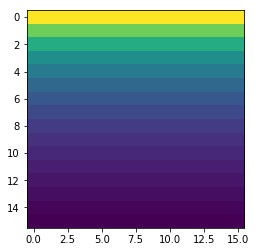

In [12]:
# Generate objective image
Xref = np.zeros((16,16))
for i in range(0,16):
    Xref[i,:] = 16./(i+5) # swing up
#     Xref[15-i, :] = 16./(i+3) # swing down
#     Xref[:, 15-i] = 16./(i+3) # swing right
#     Xref[:, i] = 16./(i+3) # swing left
Xplan = (Xref - np.min(Xref)) / (np.max(Xref) - np.min(Xref))
Xplan = Xplan.reshape(1,1,256)

# Show obejctive image
plt.figure()
plt.imshow(Xplan.reshape((16,16)))
plt.show()
print('Obejctive Image')

# Plan
Xobjective = (Xplan-Xmean)/Xstd
museq_planner = apiae_planner.sess.run(apiae_planner.museq,
                feed_dict={apiae_planner.xseq: Xobjective, apiae_planner.mu0:museq0[:,:,-1:,:]}) #museq0[:,:,-1:,:]

K_planner = params_planner['K']
museq_planner_reshape = np.reshape(museq_planner,(K_planner,n_z))
xtemp = apiae_planner.sess.run(apiae_planner.genNet.x_out,feed_dict={apiae_planner.genNet.z_in:museq_planner_reshape})
xtemp = xtemp.reshape(1,1,K_planner,params_planner['n_x'])*Xstd+Xmean

# Draw
imgs = []
fig, ax1 = plt.subplots(1,1, figsize=(10,5))
ax1.set_xticks([])
ax1.set_yticks([])
plt.tight_layout() 
for t in range(K_planner):
    im1 = ax1.imshow(xtemp[0,0,t,:].reshape(16,16), animated=True)
    imtext1 = ax1.text(.2,1,'Planning',fontsize=30,color='white')
    imgs.append([im1,imtext1])


im_ani_infer = animation.ArtistAnimation(fig, imgs, interval=200,repeat_delay=100)        
HTML(im_ani_infer.to_html5_video()) 

In [14]:
plt.close()